#### **PyTorch**

In [27]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.1+cu121
Cude is available: True
Device name: NVIDIA A100-SXM4-40GB


#### **Import Other Libraries**

In [28]:
# Standard library imports
import os
import time 

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import anthropic

import jax 
import jax.numpy as jnp 
import optax 
from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer
import time 


import concurrent.futures
import time
from tqdm import tqdm
import re 

#### **Parameters**

In [29]:
seed = 1
noise = False 
version = 4 
sample_size = 1000
test_size = 0.3
nodes = 32
lr = 2e-4
epochs = 30_000

#### **Seed**

In [30]:
np.random.seed(seed)

#### **Set Up Paths**

In [31]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [32]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-BoldItalic.ttf


#### **First Stage Function**

In [33]:
def fstage(var0, var1, var2, var3, var4):
    return 0.2*(var3 >= 3) +  0.3*(var4)  + 0.3*(var3 >= 3)*(var4)

#### **Read in Data**

In [34]:
def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n'
string1 = "Note: Free legal representaiton is available in the tenant's zip code.\n\n"
string0 = "Note:  Free legal representaiton is not available in the tenant's zip code.\n\n"

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'],
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                            string1 + 'Description:' + df['Description'].replace("\n", ""),
                            string0 + 'Description:' + df['Description'].replace("\n", ""))

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  1. + (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + np.random.normal(size=sample_size)

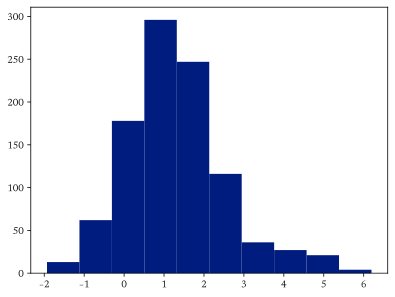

In [35]:
plt.hist(df['Outcome'].values)
plt.show()

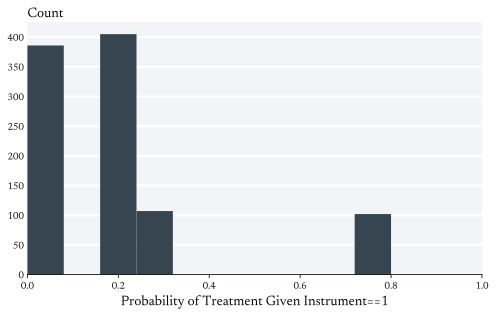

In [36]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument==1', size=14)
plt.show()

#### **Joint Distribution**

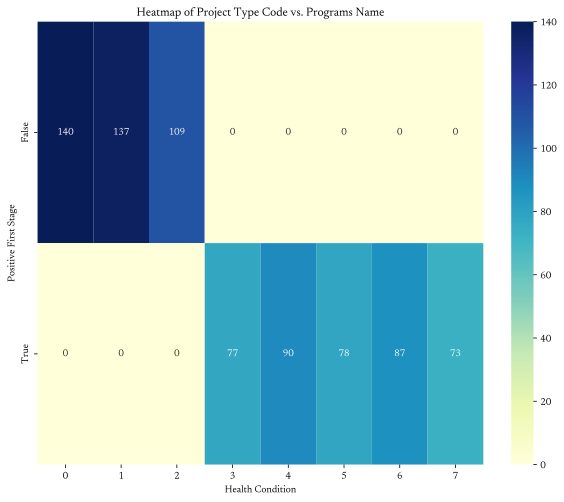

In [37]:
df['PositiveFstage'] = df['FStage_Value'].apply(lambda x : x>0.)
df_temp = df[df['Var4'] ==0]
crosstab = pd.crosstab(df_temp['PositiveFstage'], df_temp['Var3'])

# Plot the crosstab using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')

# Add titles and labels
plt.title('Heatmap of Project Type Code vs. Programs Name')
plt.xlabel('Health Condition')
plt.ylabel('Positive First Stage')

# Show the plot
plt.show()

#### **Plot**

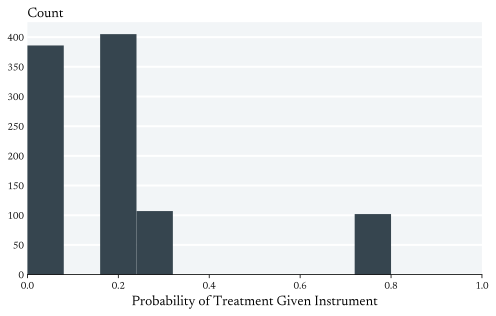

In [38]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [40]:
df['Health'] = df['Var3'].apply(lambda x: 1.0*(x>=3))

#### **Cross Tabs**

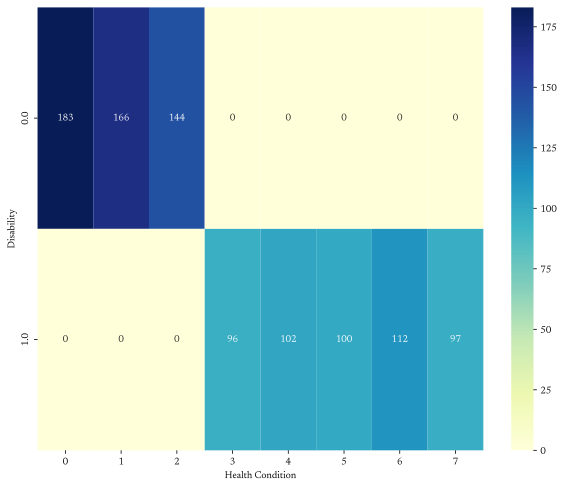

In [41]:
crosstab = pd.crosstab(df['Health'], df['Var3'])

# Plot the crosstab using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')

# Add titles and labels
plt.xlabel('Health Condition')
plt.ylabel('Disability')

# Show the plot
plt.savefig(f'heatmap_{seed}.png')
plt.show()

In [42]:
def standardize_first_column(X):
    # Create a copy of the matrix to avoid changing the original
    X_copy = X.copy()
    
    # Extract the first column
    first_column = X_copy[:, 0]
    
    # Compute the mean and standard deviation of the first column
    mean = np.mean(first_column)
    std = np.std(first_column)
    
    # Standardize the first column
    standardized_first_column = (first_column - mean) / std
    
    # Replace the first column in the copied matrix
    X_copy[:, 0] = standardized_first_column
    
    return X_copy

#df = pd.get_dummies(df, columns=['Var0', 'Var1', 'Var4'], drop_first=True)
var_columns = ['Health', 'Var4']
#var_columns = [col for col in df.columns if col.startswith('Var')] + ['Health']
#var_columns = [var for var in var_columns if var != 'Var3']

# Create a numpy matrix from the selected columns
X = df[var_columns].to_numpy().astype(float)
X = np.hstack((X, np.ones(shape=(X.shape[0], 1))))

# Feature Matrix
X_normalized = X.copy() #standardize_first_column(X)
print(f"Feature shape: \t\t{X.shape}")
print(f"Feature shape: \t\t{X_normalized.shape}")

D = jnp.array(df['Treatment'].values.reshape(-1,1)).astype(float)
Z = jnp.array(df['Instrument'].values.reshape(-1,1)).astype(float)
inputs = jnp.hstack((X_normalized, Z))

Feature shape: 		(1000, 3)
Feature shape: 		(1000, 3)


In [43]:
features = inputs.shape[1] ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes, nodes], jax.nn.relu)
final_activation_fn = jax.nn.sigmoid 
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(binary_cross_entropy, model.embellished_fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

Number of Features: 4


In [44]:
# Initialize random key
key = jax.random.PRNGKey(seed)

# Create keys
key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

# Initialize parameters
params = ModelParams.init_fn(subkey1, mlp, features)

# Split Train and Validation Data
# Shuffle the indices
idx = jax.random.permutation(subkey2, inputs.shape[0])

# Determine the indices for training and validation sets
train_size = int((1 - test_size) * inputs.shape[0])
train_indices = idx[:train_size]
val_indices = idx[train_size:]

# Create boolean masks for training and validation sets
is_in_train = jnp.isin(jnp.arange(inputs.shape[0]), train_indices)
is_in_val = jnp.isin(jnp.arange(inputs.shape[0]), val_indices)

# Train the model
params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, inputs, D, jnp.ones_like(D), is_in_train, is_in_val)

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


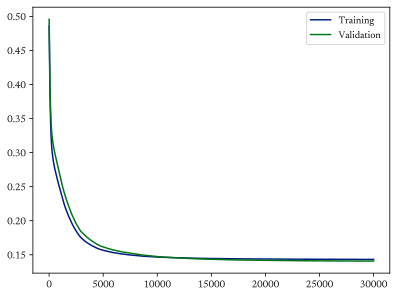

In [45]:
plt.plot(train_loss_history, label='Training')
plt.plot(val_loss_history, label='Validation')
plt.legend()
plt.show()

In [46]:
df.head()

,Var0,Var1,Var2,Var3,Var4,Description,FStage_Value,Instrument,FullDescription,Treatment,Outcome,PositiveFstage,Health
0,6,3,1022,7,0,The tenant is a middle-aged individual in thei...,0.2,1,Note: Free legal representaiton is available i...,0,1.141413,True,1.0
1,7,1,1405,4,1,The tenant is a middle-aged individual in thei...,0.8,0,Note: Free legal representaiton is not availa...,0,2.322802,True,1.0
2,0,2,1185,4,0,The tenant is a young adult in their mid-20s w...,0.2,0,Note: Free legal representaiton is not availa...,0,0.294798,True,1.0
3,6,3,1014,0,0,The tenant is a hard-working individual in the...,0.0,1,Note: Free legal representaiton is available i...,0,1.561439,False,0.0
4,8,1,1297,1,0,The tenant is a middle-aged individual in thei...,0.0,0,Note: Free legal representaiton is not availa...,0,1.171968,False,0.0


In [47]:
Dhat = np.array(model.fwd_pass(opt_params, inputs))
Dhat1 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.ones_like(Z)))))
Dhat0 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.zeros_like(Z)))))
residuals = Dhat - (0.5*Dhat1 + 0.5*Dhat0)
idx = (jnp.abs(residuals) > 0).reshape(-1,)
residuals = residuals[idx]
y =  jnp.array(df['Outcome'].values.reshape(-1,1))[idx]
est = jnp.linalg.lstsq(jnp.hstack((residuals, jnp.ones_like(residuals))), y)[0][0]
df_result = pd.DataFrame({'Estimate': est})
print(est)

[3.070201]


(0.0, 1.0)

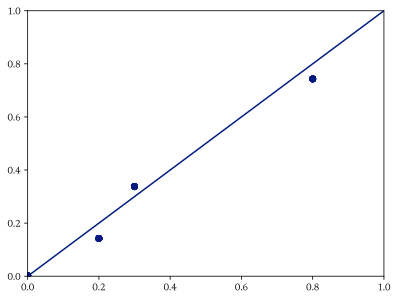

In [48]:
v = df['FStage_Value'].values
plt.scatter(v, Dhat1.reshape(-1,), alpha=0.1)
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [49]:
df['Train'] = is_in_train
df[df['Train']].groupby(['Instrument', 'Health', 'Var4'])['Treatment'].mean()

Instrument  Health  Var4
0           0.0     0       0.000000
                    1       0.000000
            1.0     0       0.000000
                    1       0.000000
1           0.0     0       0.000000
                    1       0.342857
            1.0     0       0.143885
                    1       0.742857
Name: Treatment, dtype: float64

In [50]:
df['Dhat1'] = Dhat1
df[df['Train']].groupby(['Instrument', 'Health', 'Var4'])['Dhat1'].mean()

Instrument  Health  Var4
0           0.0     0       0.002187
                    1       0.337622
            1.0     0       0.142286
                    1       0.743222
1           0.0     0       0.002187
                    1       0.337622
            1.0     0       0.142286
                    1       0.743222
Name: Dhat1, dtype: float32

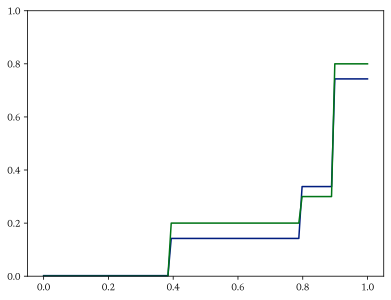

In [51]:
qs = np.linspace(0, 1, 100)
ys1 = np.quantile(Dhat1, qs)
ys2 = np.quantile(df['FStage_Value'].values, qs)
plt.plot(qs, ys1)
plt.plot(qs, ys2)
plt.ylim(0, 1)
plt.show()

In [52]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/oracle_{version}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)